In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import ticker 
import pycountry_convert as pc
import folium
import branca
from datetime import datetime, timedelta,date
from scipy.interpolate import make_interp_spline, BSpline
import plotly.express as px
import json, requests
import calmap
from keras.layers import Input, Dense, Activation, LeakyReLU, Dropout
from keras import models
from keras.optimizers import RMSprop, Adam
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [4]:
df_confirmed = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv')
df_deaths = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv')
df_covid19 = pd.read_csv("https://raw.githubusercontent.com/CSSEGISandData/COVID-19/web-data/data/cases_country.csv")
df_table = pd.read_csv("https://raw.githubusercontent.com/CSSEGISandData/COVID-19/web-data/data/cases_time.csv",parse_dates=['Last_Update'])

In [5]:
df_covid19 = df_covid19.drop(["People_Tested","People_Hospitalized","UID","ISO3","Mortality_Rate"],axis =1)

In [6]:
df_confirmed = df_confirmed.rename(columns={"Province/State":"state","Country/Region": "country"})
df_deaths = df_deaths.rename(columns={"Province/State":"state","Country/Region": "country"})
df_covid19 = df_covid19.rename(columns={"Country_Region": "country"})
df_covid19["Active"] = df_covid19["Confirmed"]-df_covid19["Recovered"]-df_covid19["Deaths"]

In [7]:
# getting all countries
countries = np.asarray(df_confirmed["country"])
countries1 = np.asarray(df_covid19["country"])


In [8]:
df_confirmed = df_confirmed.replace(np.nan, '', regex=True)
df_deaths = df_deaths.replace(np.nan, '', regex=True)

In [9]:
def plot_params(ax,axis_label= None, plt_title = None,label_size=15, axis_fsize = 15, title_fsize = 20, scale = 'linear' ):
    plt.title( plt_title,{'fontsize':title_fsize})
    plt.yscale(scale)
    plt.minorticks_on()
    xl = plt.xlabel(axis_label[0],fontsize = axis_fsize)
    yl = plt.ylabel(axis_label[1],fontsize = axis_fsize)
   

In [10]:
def visualize_covid_cases(confirmed, deaths, continent=None , country = None , state = None, period = None, figure = None, scale = "linear"):
    x = 0
    if figure == None:
        f = plt.figure(figsize=(10,10))
        ax = f.add_subplot(111)
    else :
        f = figure[0]
        ax = f.add_subplot(figure[1],figure[2],figure[3])
        
    ax.set_axisbelow(True)
    plt.tight_layout(pad=10, w_pad=5, h_pad=5)
    
    stats = [confirmed, deaths]
    label = ["Confirmed", "Deaths"]
    

    if country != None:
        params = ["country",country]
    else: 
        params = ["All", "All"]
    color = ["darkcyan","crimson"]
    marker_style = dict(linewidth=3, linestyle='-', marker='o',markersize=4, markerfacecolor='#ffffff')


    for i,stat in enumerate(stats):
        if params[1] == "All" :
            cases = np.sum(np.asarray(stat.iloc[:,5:]),axis = 0)[x:]
        else :
            cases = np.sum(np.asarray(stat[stat[params[0]] == params[1]].iloc[:,5:]),axis = 0)[x:]
        date = np.arange(1,cases.shape[0]+1)[x:]
        plt.plot(date,cases,label = label[i]+" (Total : "+str(cases[-1])+")",color=color[i],**marker_style)
        plt.fill_between(date,cases,color=color[i],alpha=0.3)

    if params[1] == "All" :
        Total_confirmed = np.sum(np.asarray(stats[0].iloc[:,5:]),axis = 0)[x:]
        Total_deaths = np.sum(np.asarray(stats[1].iloc[:,5:]),axis = 0)[x:]
    else :
        Total_confirmed =  np.sum(np.asarray(stats[0][stat[params[0]] == params[1]].iloc[:,5:]),axis = 0)[x:]
        Total_deaths = np.sum(np.asarray(stats[1][stat[params[0]] == params[1]].iloc[:,5:]),axis = 0)[x:]
        
    axis_label = ["Days","No of Cases"]
    
    plot_params(ax,axis_label,scale = scale)
    
    if params[1] == "All" :
        plt.title("COVID-19 Cases World",{'fontsize':25})
    else:   
        plt.title("COVID-19: "+params[1] ,{'fontsize':25})

    l = plt.legend(loc= "best",fontsize = 10)
    if figure == None:
        plt.show()

In [11]:
df_countries_cases = df_covid19.copy().drop(['Lat','Long_','Last_Update'],axis =1)
df_countries_cases.index = df_countries_cases["country"]
df_countries_cases = df_countries_cases.drop(['country'],axis=1)
df_countries_cases.fillna(0,inplace=True)


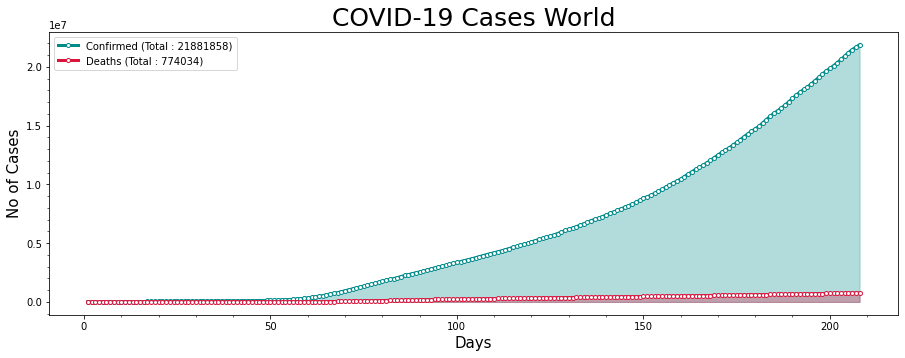

In [12]:
cols = 1
rows = 1
f = plt.figure(figsize=(15,7*rows))

visualize_covid_cases(df_confirmed, df_deaths,figure = [f,rows,cols, 1])

plt.show()

In [13]:
df_countries_cases.sort_values('Confirmed', ascending= False).style.background_gradient(cmap='Blues',subset=["Confirmed"])\
                        .background_gradient(cmap='Reds',subset=["Deaths"])\
                        .background_gradient(cmap='Greens',subset=["Recovered"])\
                        .background_gradient(cmap='Purples',subset=["Active"])\
                        .format("{:.0f}",subset=["Confirmed","Deaths","Recovered","Active"])

In [14]:
world_map = folium.Map(location=[10,0], tiles="cartodbpositron", zoom_start=2,max_zoom=6,min_zoom=2)
for i in range(0,len(df_confirmed)):
    folium.Circle(
        location=[df_confirmed.iloc[i]['Lat'], df_confirmed.iloc[i]['Long']],
        tooltip = "<h5 style='text-align:center;font-weight: bold'>"+df_confirmed.iloc[i]['country']+"</h5>"+
                    "<div style='text-align:center;'>"+str(np.nan_to_num(df_confirmed.iloc[i]['state']))+"</div>"+
                    "<hr style='margin:10px;'>"+
                    "<ul style='color: #444;list-style-type:circle;align-item:left;padding-left:20px;padding-right:20px'>"+
        "<li>Confirmed: "+str(df_confirmed.iloc[i,-1])+"</li>"+
        "<li>Deaths:   "+str(df_deaths.iloc[i,-1])+"</li>"+
        "</ul>",
        radius=(int((np.log(df_confirmed.iloc[i,-1]+1.00001)))+0.2)*50000,
        color='#ff6600',
        fill_color='#ff8533',
        fill=True).add_to(world_map)

world_map


In [15]:
temp_df = pd.DataFrame(df_countries_cases['Confirmed'])
temp_df = temp_df.reset_index()
fig = px.choropleth(temp_df, locations="country",
                    color=np.log10(temp_df["Confirmed"]), # lifeExp is a column of gapminder
                    hover_name="country", # column to add to hover information
                    hover_data=["Confirmed"],
                    color_continuous_scale=px.colors.sequential.Plasma,locationmode="country names")
fig.update_geos(fitbounds="locations", visible=False)
fig.update_layout(title_text="Confirmed Cases Heat Map (Log Scale)")
fig.update_coloraxes(colorbar_title="Confirmed Cases(Log Scale)",colorscale="Blues")
# fig.to_image("Global Heat Map confirmed.png")
fig.show()

In [16]:
temp_df = pd.DataFrame(df_countries_cases['Deaths'])
temp_df = temp_df.reset_index()
fig = px.choropleth(temp_df, locations="country",
                    color=np.log10(temp_df["Deaths"]+1), # lifeExp is a column of gapminder
                    hover_name="country", # column to add to hover information
                    hover_data=["Deaths"],
                    color_continuous_scale=px.colors.sequential.Plasma,locationmode="country names")
fig.update_geos(fitbounds="locations", visible=False)
fig.update_layout(title_text="Deaths Heat Map (Log Scale)")
fig.update_coloraxes(colorbar_title="Deaths (Log Scale)",colorscale="Reds")
# fig.to_image("Global Heat Map deaths.png")
fig.show()

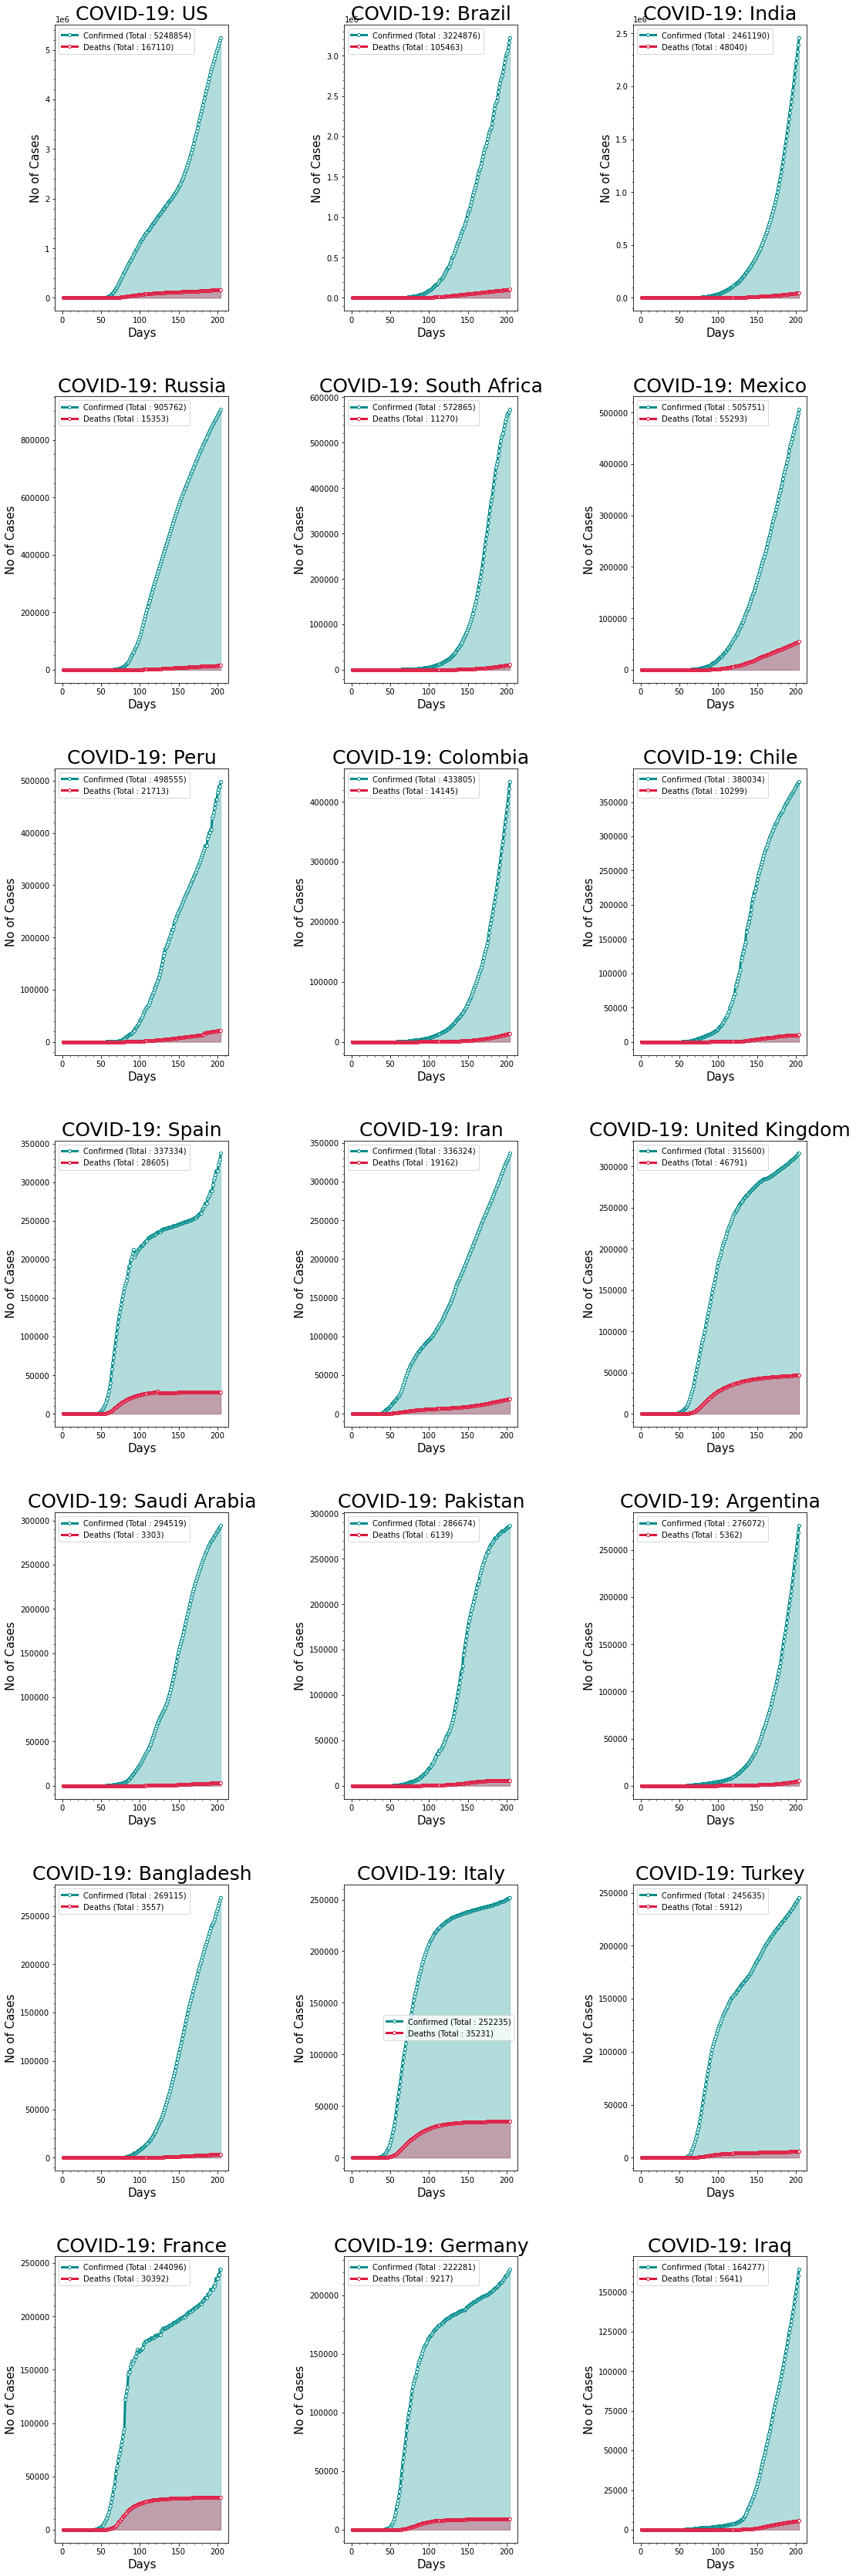

In [15]:
cols =3
rows = int(np.ceil(countries.shape[0]/cols))
f = plt.figure(figsize=(18,7*rows))
for i,country in enumerate(countries):
    visualize_covid_cases(df_confirmed, df_deaths,country = country,figure = [f,rows,cols, i+1])

plt.show()

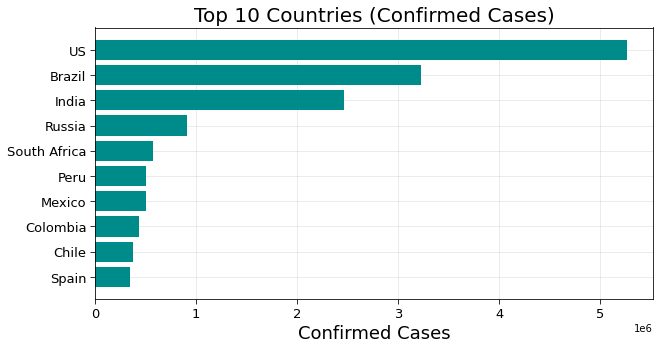

In [16]:
f = plt.figure(figsize=(10,5))
plt.axes(axisbelow=True)
plt.barh(df_countries_cases.sort_values('Confirmed')["Confirmed"].index[-10:],df_countries_cases.sort_values('Confirmed')["Confirmed"].values[-10:],color="darkcyan")
plt.tick_params(size=5,labelsize = 13)
plt.xlabel("Confirmed Cases",fontsize=18)
plt.title("Top 10 Countries (Confirmed Cases)",fontsize=20)
plt.grid(alpha=0.3)

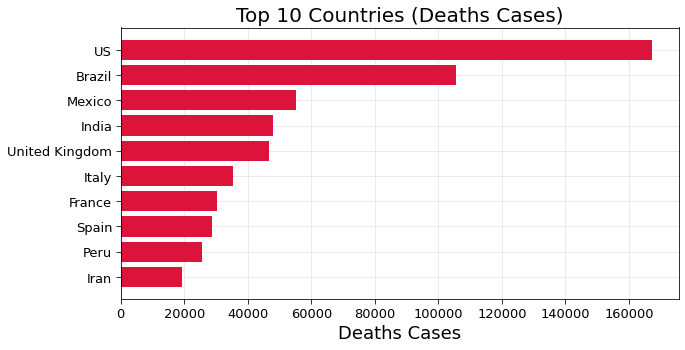

In [17]:
f = plt.figure(figsize=(10,5))
plt.axes(axisbelow=True)
plt.barh(df_countries_cases.sort_values('Deaths')["Deaths"].index[-10:],df_countries_cases.sort_values('Deaths')["Deaths"].values[-10:],color="crimson")
plt.tick_params(size=5,labelsize = 13)
plt.xlabel("Deaths Cases",fontsize=18)
plt.title("Top 10 Countries (Deaths Cases)",fontsize=20)
plt.grid(alpha=0.3,which='both')


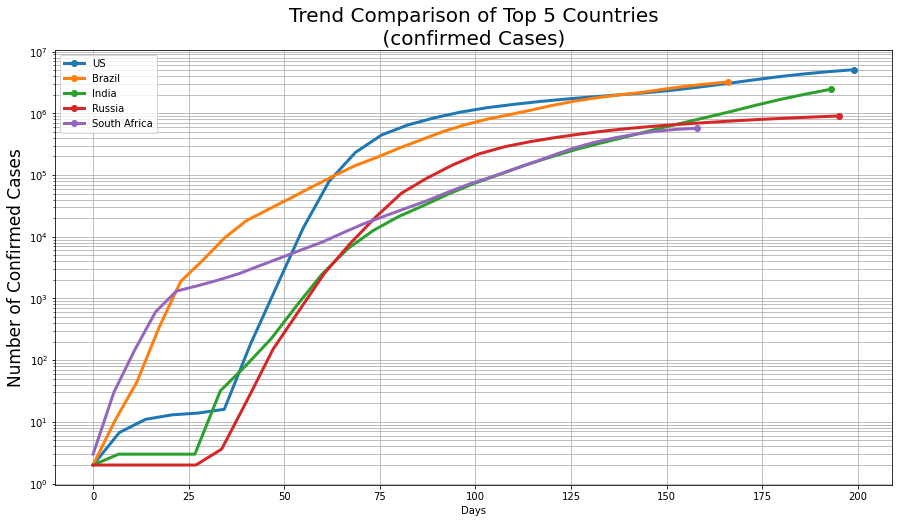

In [18]:
temp = df_confirmed.groupby('country').sum().drop(["Lat","Long"],axis =1).sort_values(df_confirmed.columns[-1], ascending= False)

threshold = 1
f = plt.figure(figsize=(15,8))

for i,country in enumerate(temp.index):
    if i >= 5:
        continue
    days = 200
    t = temp.loc[temp.index== country].values[0]
    t = t[t>threshold][:days] 
    date = np.arange(0,len(t[:days]))
    xnew = np.linspace(date.min(), date.max(), 30)
    spl = make_interp_spline(date, t, k=1)
    power_smooth = spl(xnew)
    plt.plot(xnew,power_smooth,'-o',label = country,linewidth =3, markevery=[-1])

plt.tick_params(labelsize = 10)        
plt.xlabel("Days",fontsize=10)
plt.ylabel("Number of Confirmed Cases",fontsize=17)
plt.title("Trend Comparison of Top 5 Countries\n (confirmed Cases) ",fontsize=20)
plt.legend(loc = "upper left")
plt.yscale("log")
plt.grid(which="both")

plt.show()

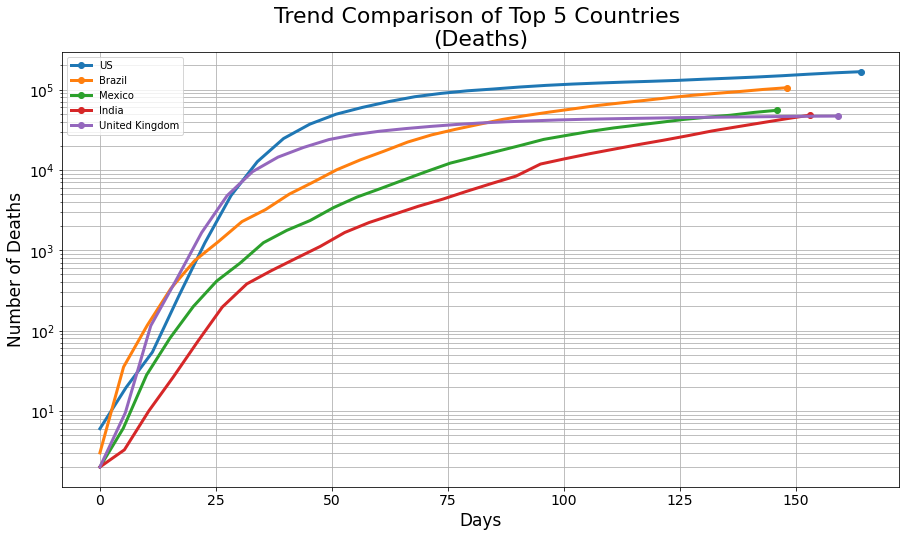

In [19]:
temp = df_deaths.groupby('country').sum().drop(["Lat","Long"],axis =1).sort_values(df_deaths.columns[-1], ascending= False)

threshold = 1
f = plt.figure(figsize=(15,8))
for i,country in enumerate(temp.index):
    if i >= 5:
        break
    days = 200
    t = temp.loc[temp.index== country].values[0]
    t = t[t>threshold][:days]
    date = np.arange(0,len(t[:days]))
    xnew = np.linspace(date.min(), date.max(), 30)
    spl = make_interp_spline(date, t, k=1)  # type: BSpline
    power_smooth = spl(xnew)
    plt.plot(xnew,power_smooth,'-o',label = country,linewidth =3, markevery=[-1])

plt.tick_params(labelsize = 14)        
plt.xlabel("Days",fontsize=17)
plt.ylabel("Number of Deaths",fontsize=17)
plt.title("Trend Comparison of Top 5 Countries \n(Deaths)",fontsize=22)
plt.legend(loc = "upper left")
plt.yscale("log")
plt.grid(which="both")
plt.show()

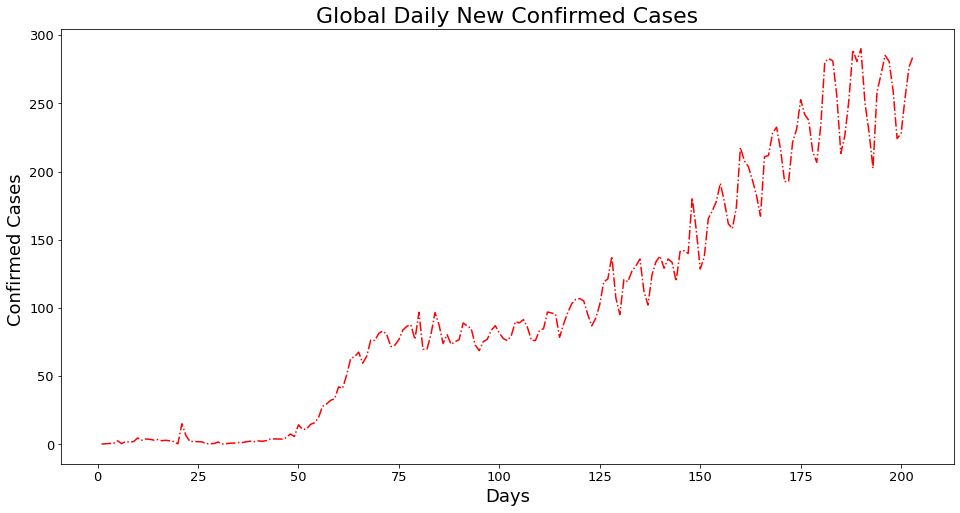

In [20]:
f = plt.figure(figsize=(16,8))
temp_data = np.nan_to_num(df_confirmed.sum()[5:].diff())
date = np.arange(0,len(temp_data))
plt.plot(date,temp_data/1000,"-.",color="red")
plt.title("Global Daily New Confirmed Cases",{'fontsize':22})
plt.xlabel("Days",fontsize =18)
plt.ylabel("Confirmed Cases ",fontsize =18)
plt.tick_params(labelsize = 13) 
plt.show()

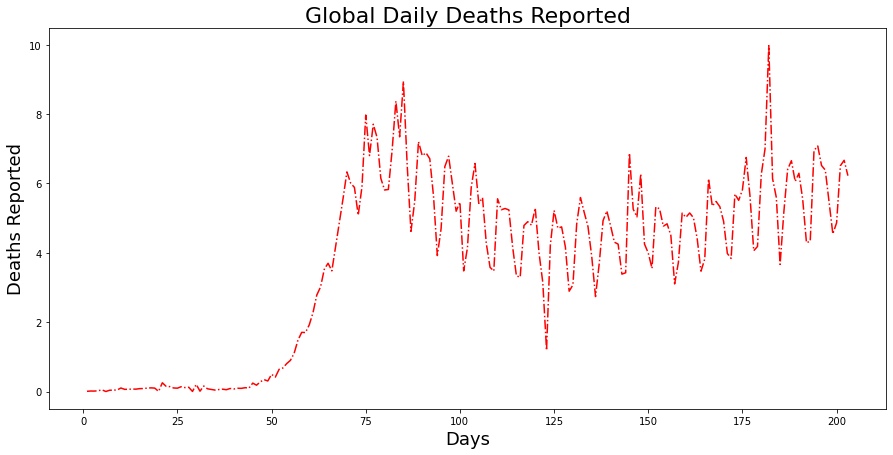

In [21]:
temp_data = df_deaths.sum()[5:].diff()
date = np.arange(0,len(temp_data))

f = plt.figure(figsize=(15,7))
plt.plot(date,temp_data/1000,"-.",color="red")
plt.title("Global Daily Deaths Reported",{'fontsize':22})
plt.xlabel("Days",fontsize =18)
plt.ylabel("Deaths Reported",fontsize =18)
plt.show()

In [ ]:
def plot_params(ax,axis_label= None, plt_title = None,label_size=15, axis_fsize = 15, title_fsize = 20, scale = 'linear' ):
    plt.title( plt_title,{'fontsize':title_fsize})
    plt.yscale(scale)
    plt.minorticks_on()
    xl = plt.xlabel(axis_label[0],fontsize = axis_fsize)
    yl = plt.ylabel(axis_label[1],fontsize = axis_fsize)
    

def visualize_covid_cases(confirmed, deaths, continent=None , country = None , state = None, period = None, figure = None, scale = "linear"):

        f = plt.figure(figsize=(10,10))
        f = figure[0]
        ax = f.add_subplot(figure[1],figure[2],figure[3])
        
    ax.set_axisbelow(True)
    plt.tight_layout(pad=10, w_pad=5, h_pad=5)
    
    stats = [confirmed, deaths]
    
    color = ["darkcyan","crimson"]
    marker_style = dict(linewidth=3, linestyle='-', marker='o',markersize=4, markerfacecolor='#ffffff')

    for i,stat in enumerate(stats):
        
        Total_confirmed = np.sum(np.asarray(stats[0].iloc[:,5:]),axis = 0)
        Total_deaths = np.sum(np.asarray(stats[1].iloc[:,5:]),axis = 0)
        date = np.arange(1,cases.shape[0]+1)[x:]
        plt.plot(date,cases,label = label[i]+" (Total : "+str(cases[-1])+")",color=color[i],**marker_style)
        plt.fill_between(date,cases,color=color[i],alpha=0.3)
        
    axis_label = ["Days","No of Cases"]
    
    plot_params(ax,axis_label,scale = scale)
    plt.title("COVID-19: "+params[1] ,{'fontsize':25})

    l = plt.legend(loc= "best",fontsize = 10)
    if figure == None:
        plt.show()
